# The Dual-Adstock Problem: A Diagnostic Demonstration

**Reference:** Cain, P.M. (2025). "Long-term advertising effects: The Adstock illusion." *Applied Marketing Analytics*, 11(1), 23-42.

## Executive Summary

This notebook demonstrates a critical problem in Marketing Mix Modeling:

**Using high-retention adstock (λ ≥ 0.95) to measure "long-term effects" can produce spurious results** - the model finds effects that don't actually exist.

### Why This Matters:
- Many MMM vendors use dual-adstock with λ=0.99 for "brand-building"
- The model can look good (high R², significant coefficients)
- But diagnostics reveal it's correlating with trend, not measuring real effects
- This leads to incorrect ROI estimates and budget allocation

### What We'll Show:
1. **Simulated example**: Data where we KNOW there's no long-term effect
2. **The problem**: Dual-adstock finds one anyway
3. **The diagnostics**: How to detect this issue
4. **Your data**: How to check your own models

---

long_term_effects/mmm_diagnostics.py

In [6]:
!wget -O mmm_diagnostics.py https://raw.githubusercontent.com/growthdynamics/shared_assets/main/long_term_effects/mmm_diagnostics.py

# Import the diagnostic module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import our diagnostic functions
from mmm_diagnostics import (
    simulate_marketing_data,
    fit_dual_adstock_model,
    plot_diagnostic_dashboard,
    create_comparison_table,
    check_your_model
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

%matplotlib inline

--2026-01-15 13:38:15--  https://raw.githubusercontent.com/growthdynamics/shared_assets/main/long_term_effects/mmm_diagnostics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16960 (17K) [text/plain]
Saving to: ‘mmm_diagnostics.py’

mmm_diagnostics.py  100%[===================>]  16.56K  --.-KB/s    in 0s      

2026-01-15 13:38:15 (128 MB/s) - ‘mmm_diagnostics.py’ saved [16960/16960]



## Part 1: The Controlled Experiment

We'll create simulated data where we **know the ground truth**:
- TV advertising causes **short-term activation only**
- Base sales evolve **randomly** (not driven by TV)
- Therefore: **NO long-term TV effects exist**

Then we'll apply dual-adstock and see what happens...

In [7]:
# Generate data with NO long-term effects
data = simulate_marketing_data(
    n_periods=156,  # 3 years of weekly data
    has_true_long_term=False,  # THIS IS KEY: No long-term effects!
    seed=42
)

print("Data generated with:")
print("  • TV causes short-term activation spikes (decay rate 0.7)")
print("  • Base sales drift randomly (NOT driven by TV)")
print("  • Therefore: NO long-term TV effects exist\n")

# Look at the data
data.head()

Data generated with:
  • TV causes short-term activation spikes (decay rate 0.7)
  • Base sales drift randomly (NOT driven by TV)
  • Therefore: NO long-term TV effects exist



,sales,tv,base,activation
0,1001.891422,0.0,1000.000000,0.0
1,973.164001,0.0,991.981722,0.0
2,1044.175243,0.0,1005.821879,0.0
3,1039.015318,0.0,1019.873932,0.0
4,1102.644808,0.0,1033.797189,0.0


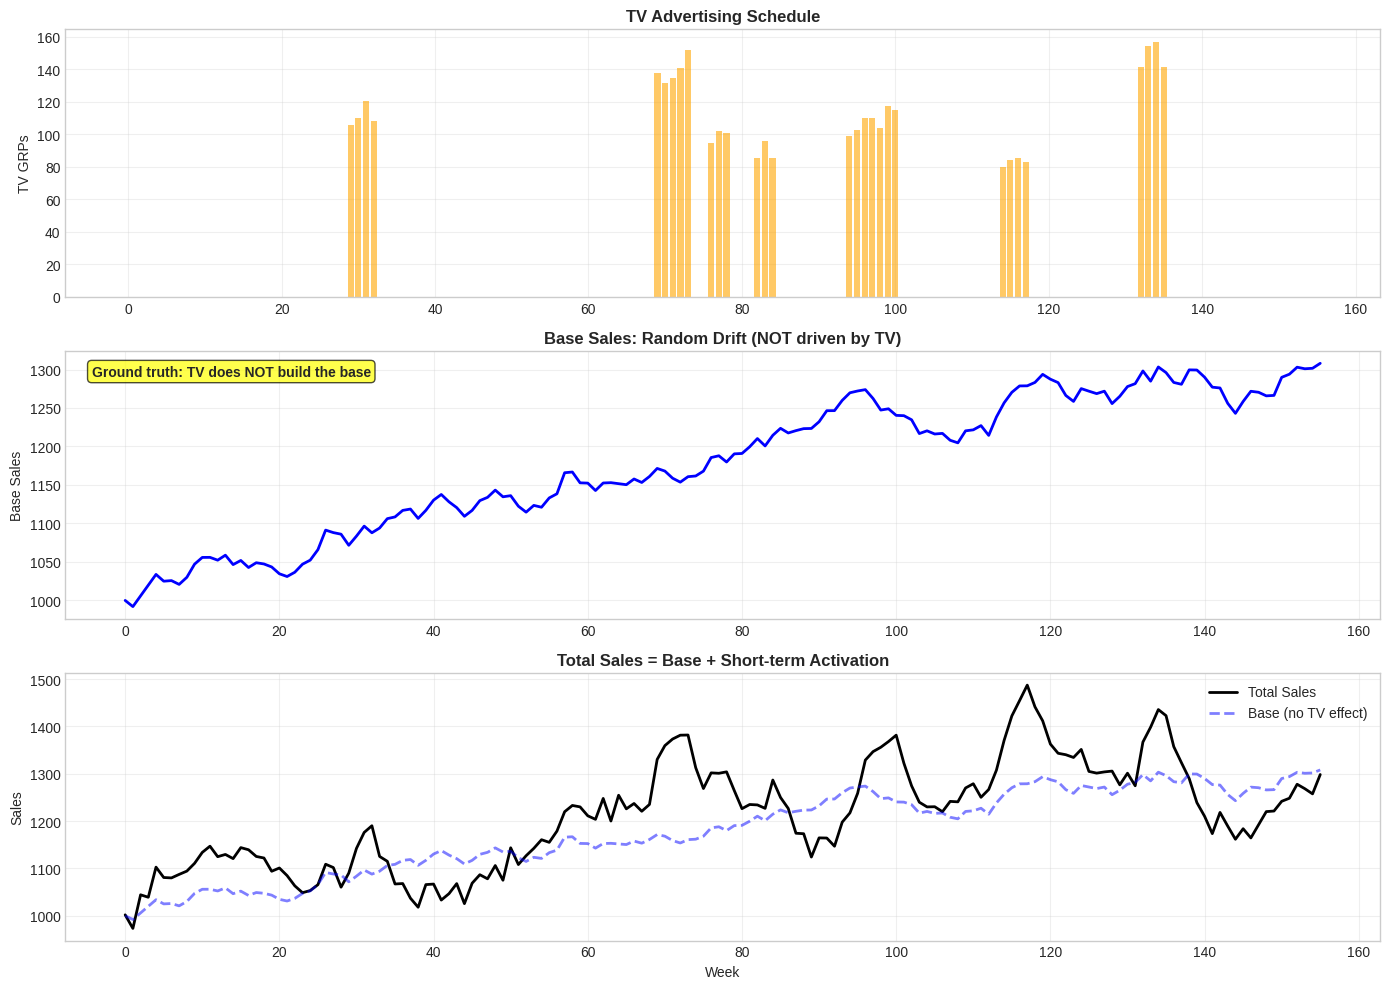


📊 Key observation: Base sales drift randomly - they're NOT trending up with TV!


In [8]:
# Visualize the ground truth
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Panel 1: TV campaigns
axes[0].bar(data.index, data['tv'], alpha=0.6, color='orange')
axes[0].set_title('TV Advertising Schedule', fontsize=12, fontweight='bold')
axes[0].set_ylabel('TV GRPs')
axes[0].grid(True, alpha=0.3)

# Panel 2: Base sales (no TV effect)
axes[1].plot(data['base'], linewidth=2, color='blue')
axes[1].set_title('Base Sales: Random Drift (NOT driven by TV)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Base Sales')
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.95, 'Ground truth: TV does NOT build the base',
             transform=axes[1].transAxes, fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
             verticalalignment='top')

# Panel 3: Total sales (base + activation)
axes[2].plot(data['sales'], linewidth=2, color='black', label='Total Sales')
axes[2].plot(data['base'], linewidth=2, color='blue', alpha=0.5,
             linestyle='--', label='Base (no TV effect)')
axes[2].set_title('Total Sales = Base + Short-term Activation', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Week')
axes[2].set_ylabel('Sales')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key observation: Base sales drift randomly - they're NOT trending up with TV!")

## Part 2: Apply Dual-Adstock Model

Now let's fit a standard dual-adstock model:
- Short-term: λ = 0.30 (half-life ~1.4 weeks)
- Long-term: λ = 0.99 (half-life ~69 weeks)

Remember: **We KNOW there's no long-term effect in this data.**

In [9]:
# Fit the dual-adstock model
results = fit_dual_adstock_model(
    sales=data['sales'].values,
    tv=data['tv'].values,
    short_retention=0.30,
    long_retention=0.99
)

# Show results table
print("\n" + "="*70)
print("DUAL-ADSTOCK MODEL RESULTS")
print("="*70 + "\n")

results_table = create_comparison_table(results)
print(results_table.to_string(index=False))

# Show warning if spurious
if results['warning_message']:
    print("\n" + "="*70)
    print(results['warning_message'])
    print("="*70)


DUAL-ADSTOCK MODEL RESULTS

                Metric  Value                            Interpretation
                    R² 0.6891  Higher is better (but can be misleading)
Short-term coefficient 0.7897              Short-term activation effect
 Long-term coefficient 0.0890                  Claimed long-term effect
         Durbin-Watson 0.2088      Should be ~2.0 (below 1.5 = problem)
     Ljung-Box p-value 0.0000 Should be >0.05 (below = autocorrelation)
  Spurious regression? ⚠️ YES Diagnostics indicate spurious correlation

⚠️  SPURIOUS REGRESSION DETECTED:
   Durbin-Watson = 0.209 (should be ~2.0)
   Ljung-Box p-value = 0.0000 (should be >0.05)
   
   The 'long-term effect' may be a statistical artifact,
   not a real brand-building impact.


## Part 3: The Critical Diagnostics

Let's look at the comprehensive diagnostics dashboard.

### What to look for:

**Row 3 (bottom row) is THE MOST IMPORTANT:**

1. **Durbin-Watson (DW) Statistic**
   - Should be ~2.0
   - If < 1.5: SEVERE autocorrelation → spurious regression
   - Measures whether residuals are independent

2. **Ljung-Box Test**
   - Tests if residuals are white noise
   - p-value should be > 0.05
   - If < 0.05: residuals have structure → model is missing something

3. **Residual Plot**
   - Should look like random noise
   - If you see patterns: model is broken

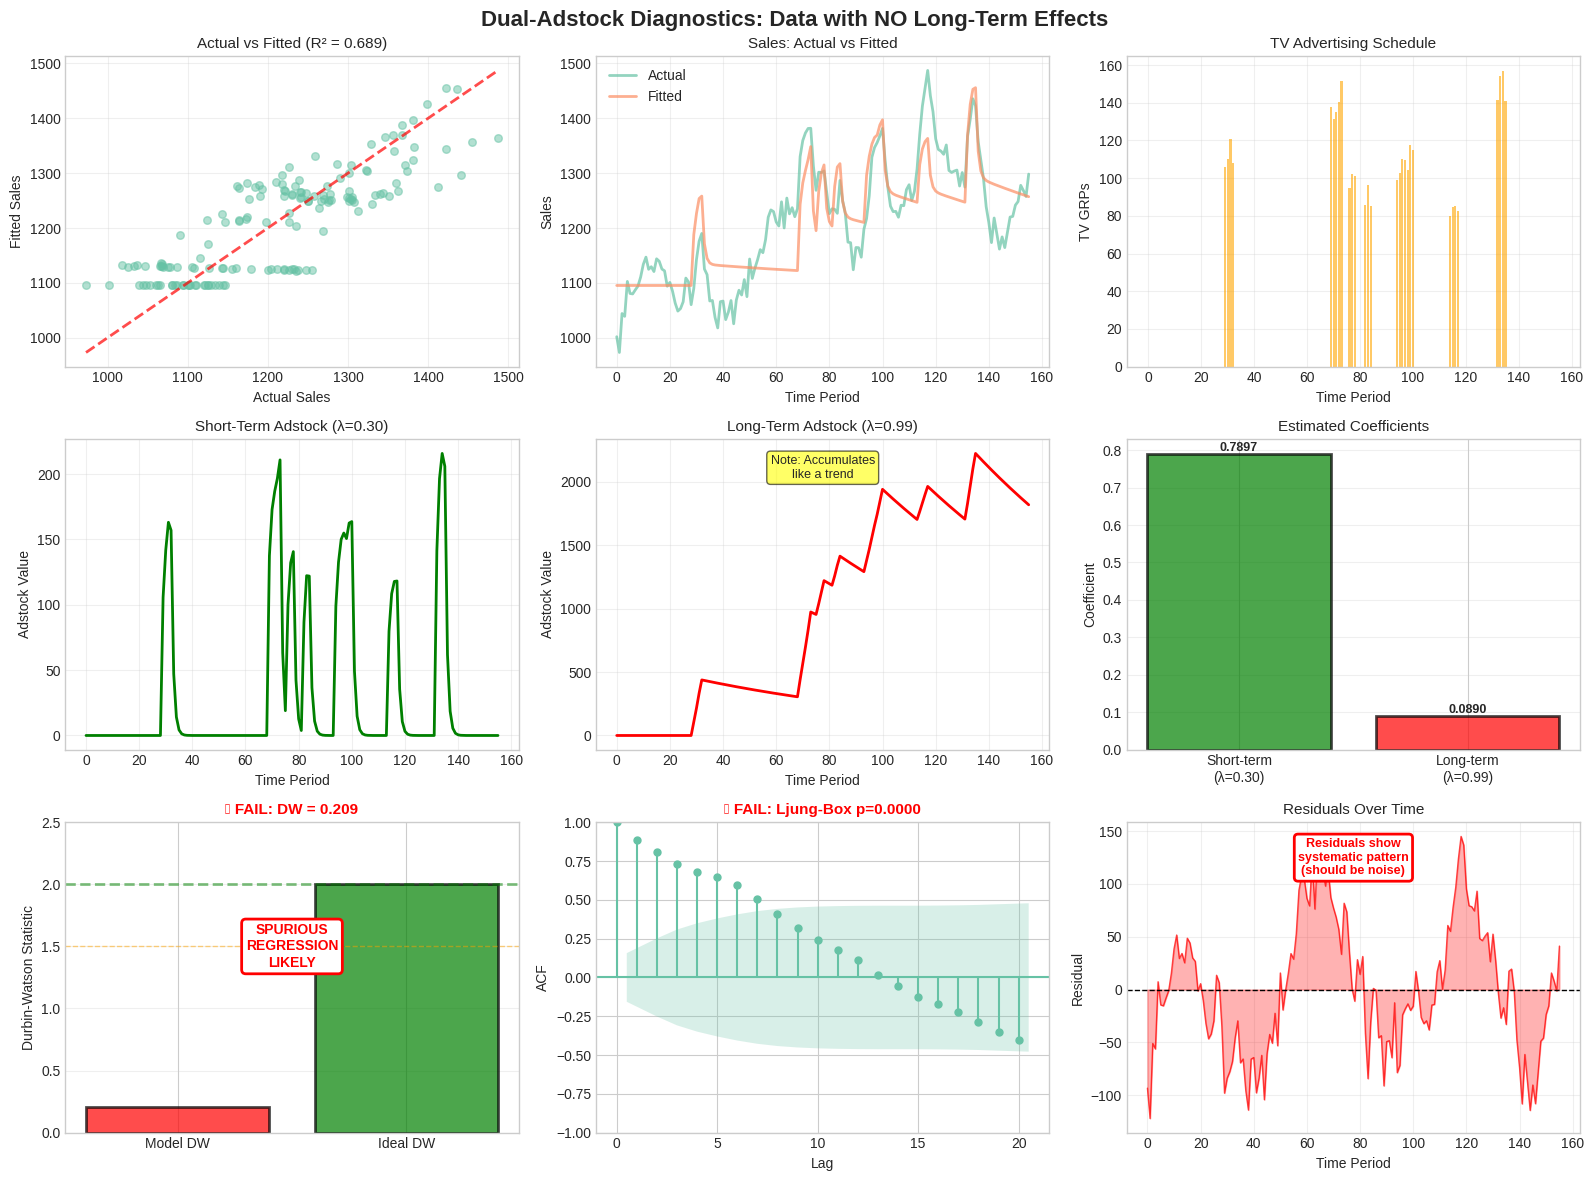

In [10]:
# Create comprehensive diagnostic dashboard
fig = plot_diagnostic_dashboard(
    sales=data['sales'].values,
    tv=data['tv'].values,
    results=results,
    title="Dual-Adstock Diagnostics: Data with NO Long-Term Effects"
)

plt.show()

## Part 4: Understanding What Went Wrong

### The Problem:

The high-retention adstock (λ=0.99) doesn't decay like a normal lag structure. Instead:

1. **It accumulates like a trend** (see middle row, center panel)
2. **Base sales also have a trend** (random drift)
3. **The two trends correlate** (by pure chance)
4. **Result**: Model claims TV drives base sales (it doesn't!)

### This is Spurious Regression:

- Two trending variables correlate
- Not because one causes the other
- But because they both happen to be trending
- Classic statistical trap first identified by Granger & Newbold (1974)

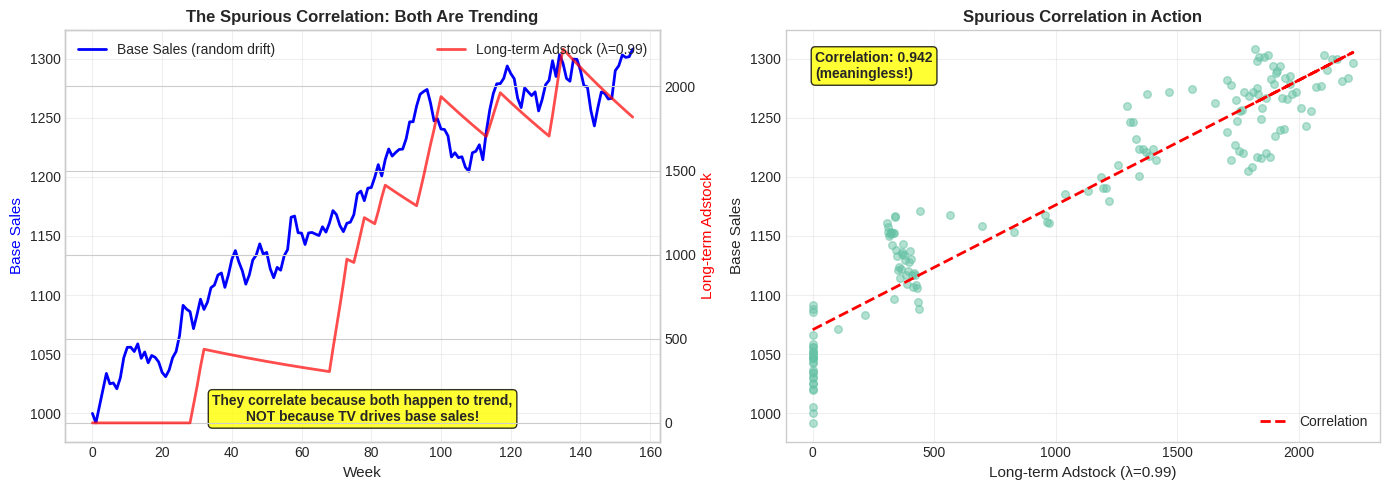


🎯 This is why Durbin-Watson is so low: the model is just fitting two trends,
   not capturing the true relationship between TV and sales.


In [11]:
# Let's visualize the spurious correlation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Both are trending
ax1 = axes[0]
ax1_twin = ax1.twinx()

ax1.plot(data['base'], linewidth=2, color='blue', label='Base Sales (random drift)')
ax1_twin.plot(results['tv_long_adstock'], linewidth=2, color='red',
              label='Long-term Adstock (λ=0.99)', alpha=0.7)

ax1.set_xlabel('Week', fontsize=11)
ax1.set_ylabel('Base Sales', fontsize=11, color='blue')
ax1_twin.set_ylabel('Long-term Adstock', fontsize=11, color='red')
ax1.set_title('The Spurious Correlation: Both Are Trending',
              fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

ax1.text(0.5, 0.05, 'They correlate because both happen to trend,\nNOT because TV drives base sales!',
         transform=ax1.transAxes, ha='center', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# Panel 2: The correlation
axes[1].scatter(results['tv_long_adstock'], data['base'], alpha=0.5, s=30)
z = np.polyfit(results['tv_long_adstock'], data['base'], 1)
p = np.poly1d(z)
axes[1].plot(results['tv_long_adstock'], p(results['tv_long_adstock']),
             'r--', linewidth=2, label=f'Correlation')
axes[1].set_xlabel('Long-term Adstock (λ=0.99)', fontsize=11)
axes[1].set_ylabel('Base Sales', fontsize=11)
axes[1].set_title('Spurious Correlation in Action', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

corr = np.corrcoef(results['tv_long_adstock'], data['base'])[0, 1]
axes[1].text(0.05, 0.95, f'Correlation: {corr:.3f}\n(meaningless!)',
             transform=axes[1].transAxes, fontsize=10, fontweight='bold',
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n🎯 This is why Durbin-Watson is so low: the model is just fitting two trends,")
print("   not capturing the true relationship between TV and sales.")

## Part 5: Check Your Own Models

Now let's see how to check YOUR marketing mix models for this problem.

### Example with your data:

```python
# Load your data
your_sales = ...  # Your sales data (log-transformed recommended)
your_tv = ...     # Your TV data

# Quick check
results = check_your_model(your_sales, your_tv)

# Full diagnostics
fig = plot_diagnostic_dashboard(your_sales, your_tv, results)
```

### Critical thresholds:
- **Durbin-Watson < 1.5**: PROBLEM (likely spurious)
- **Ljung-Box p < 0.05**: PROBLEM (residuals not white noise)
- **Both pass**: Still be cautious, but less concerning

In [12]:
# Example: Let's test with another simulated dataset
print("Testing with a different random seed...\n")

data2 = simulate_marketing_data(n_periods=156, has_true_long_term=False, seed=123)
results2 = check_your_model(data2['sales'].values, data2['tv'].values)

Testing with a different random seed...

DUAL-ADSTOCK MODEL DIAGNOSTIC CHECK

R² = 0.4359
Short-term coefficient = 0.6306
Long-term coefficient = -0.0759

Durbin-Watson statistic = 0.2262
Ljung-Box p-value = 0.000000

VERDICT:
❌ SPURIOUS REGRESSION DETECTED

Your model shows signs of spurious correlation:
  • Durbin-Watson (0.226) is below 1.5
  • Ljung-Box test rejects white noise (p=0.0000)

The claimed 'long-term effect' may be a statistical artifact.
The high-retention adstock is likely just correlating with trend.


## Part 6: Key Takeaways

### 🚨 The Problem:

1. **Dual-adstock with high retention (λ ≥ 0.95) is unreliable**
   - Creates deterministic drift, not decay
   - Correlates with any trend in the data
   - Finds "long-term effects" even when none exist

2. **Standard fit statistics are misleading**
   - R² can look good
   - Coefficients appear significant
   - But the model is fundamentally broken

3. **Diagnostics reveal the truth**
   - Low Durbin-Watson (< 1.5)
   - Ljung-Box test failure (p < 0.05)
   - Residuals show systematic patterns

### ⚠️ What This Means:

- Many commercial MMM reports may overstate long-term effects
- Budget allocation based on these models could be suboptimal
- ROI calculations for brand-building may be inflated

### 🔍 What to Do:

1. **Always check diagnostics** (DW, Ljung-Box, residual plots)
2. **Be skeptical of high-retention adstock** (λ > 0.95)
3. **Consider alternative approaches** (though none are perfect):
   - Shorter retention rates (λ = 0.5-0.8)
   - Explicit trend modeling
   - Time series decomposition methods
   - Brand equity surveys as additional validation

### 📚 Further Reading:

- Cain, P.M. (2025). "Long-term advertising effects: The Adstock illusion." *Applied Marketing Analytics*, 11(1), 23-42.
- Granger, C. & Newbold, P. (1974). "Spurious regressions in econometrics." *Journal of Econometrics*, 2(2), 111-120.
- Dekimpe, M. & Hanssens, D. (1995). "The persistence of marketing effects on sales." *Marketing Science*, 14(1), 1-21.

---

## Questions for Discussion:

1. Have you checked the Durbin-Watson statistics in your MMMs?
2. What retention rates are you using for "long-term" effects?
3. How do we validate long-term effects without perfect statistical methods?
4. What additional evidence (surveys, experiments) can support MMM findings?